In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import dask.dataframe as dd
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import shapely

In [29]:
plt.rcParams['savefig.dpi'] = 150

In [3]:
# pd.options.display.max_rows = 1000

In [4]:
import dask.distributed
client = dask.distributed.Client('localhost:8786')
client.restart()

<Client: scheduler='tcp://localhost:8786' processes=4 cores=4>

In [5]:
taxi = dd.read_parquet('/bigdata/all_trips.parquet', columns=[
        'pickup_datetime', 
        'pickup_taxizone_id', 
#         'dropoff_datetime', 
#         'dropoff_taxizone_id', 
#         'dropoff_datetime', 
#         'trip_type', 
#         'trip_distance'
    ])

In [6]:
taxi.columns

Index(['pickup_datetime', 'pickup_taxizone_id'], dtype='object')

In [7]:
mask = (taxi['pickup_datetime'] > '2016-07-01') & (taxi['pickup_datetime'] < '2017-01-01')

In [8]:
mask.tail()

503862    True
503863    True
503864    True
503865    True
503866    True
Name: pickup_datetime, dtype: bool

In [9]:
taxi2 = taxi[mask]

In [10]:
taxi2.map_partitions(lambda x: x.shape[0], meta=float).compute()

0            0
1            0
2            0
3            0
4            0
5            0
6            0
7            0
8            0
9            0
10           0
11           0
12           0
13           0
14           0
15           0
16           0
17           0
18           0
19           0
20           0
21           0
22           0
23           0
24           0
25           0
26           0
27           0
28           0
29           0
         ...  
3165    709622
3166    708847
3167    707547
3168    710995
3169    709288
3170    707694
3171    709902
3172    709324
3173    708160
3174    710883
3175    710209
3176    714327
3177    710922
3178    710524
3179    163884
3180    708749
3181    709759
3182    710380
3183    708745
3184    707785
3185    710154
3186    709069
3187    707554
3188    709690
3189    710756
3190    710944
3191    715233
3192    712668
3193    714055
3194    503867
dtype: int64

In [11]:
taxi2.tail()

,pickup_datetime,pickup_taxizone_id
503862,2016-12-31 23:59:54,68.0
503863,2016-12-31 23:59:54,166.0
503864,2016-12-31 23:59:54,68.0
503865,2016-12-31 23:59:54,236.0
503866,2016-12-31 23:59:58,144.0


In [12]:
taxi2 = taxi2.set_index('pickup_datetime', npartitions=70)

In [13]:
taxi2 = taxi2.reset_index()

In [14]:
taxi2['pickup_taxizone_id'] = taxi2.pickup_taxizone_id.astype(int)

In [15]:
taxi2 = client.persist(taxi2)

In [16]:
z = taxi2.groupby('pickup_taxizone_id').count().compute()

In [17]:
z = z.sort_index()

In [18]:
z.pickup_datetime = np.max((z.pickup_datetime, np.ones(z.pickup_datetime.shape[0], dtype=np.int64)), axis=0)
z['logN'] = np.log10(z.pickup_datetime)

/home/shekhar/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


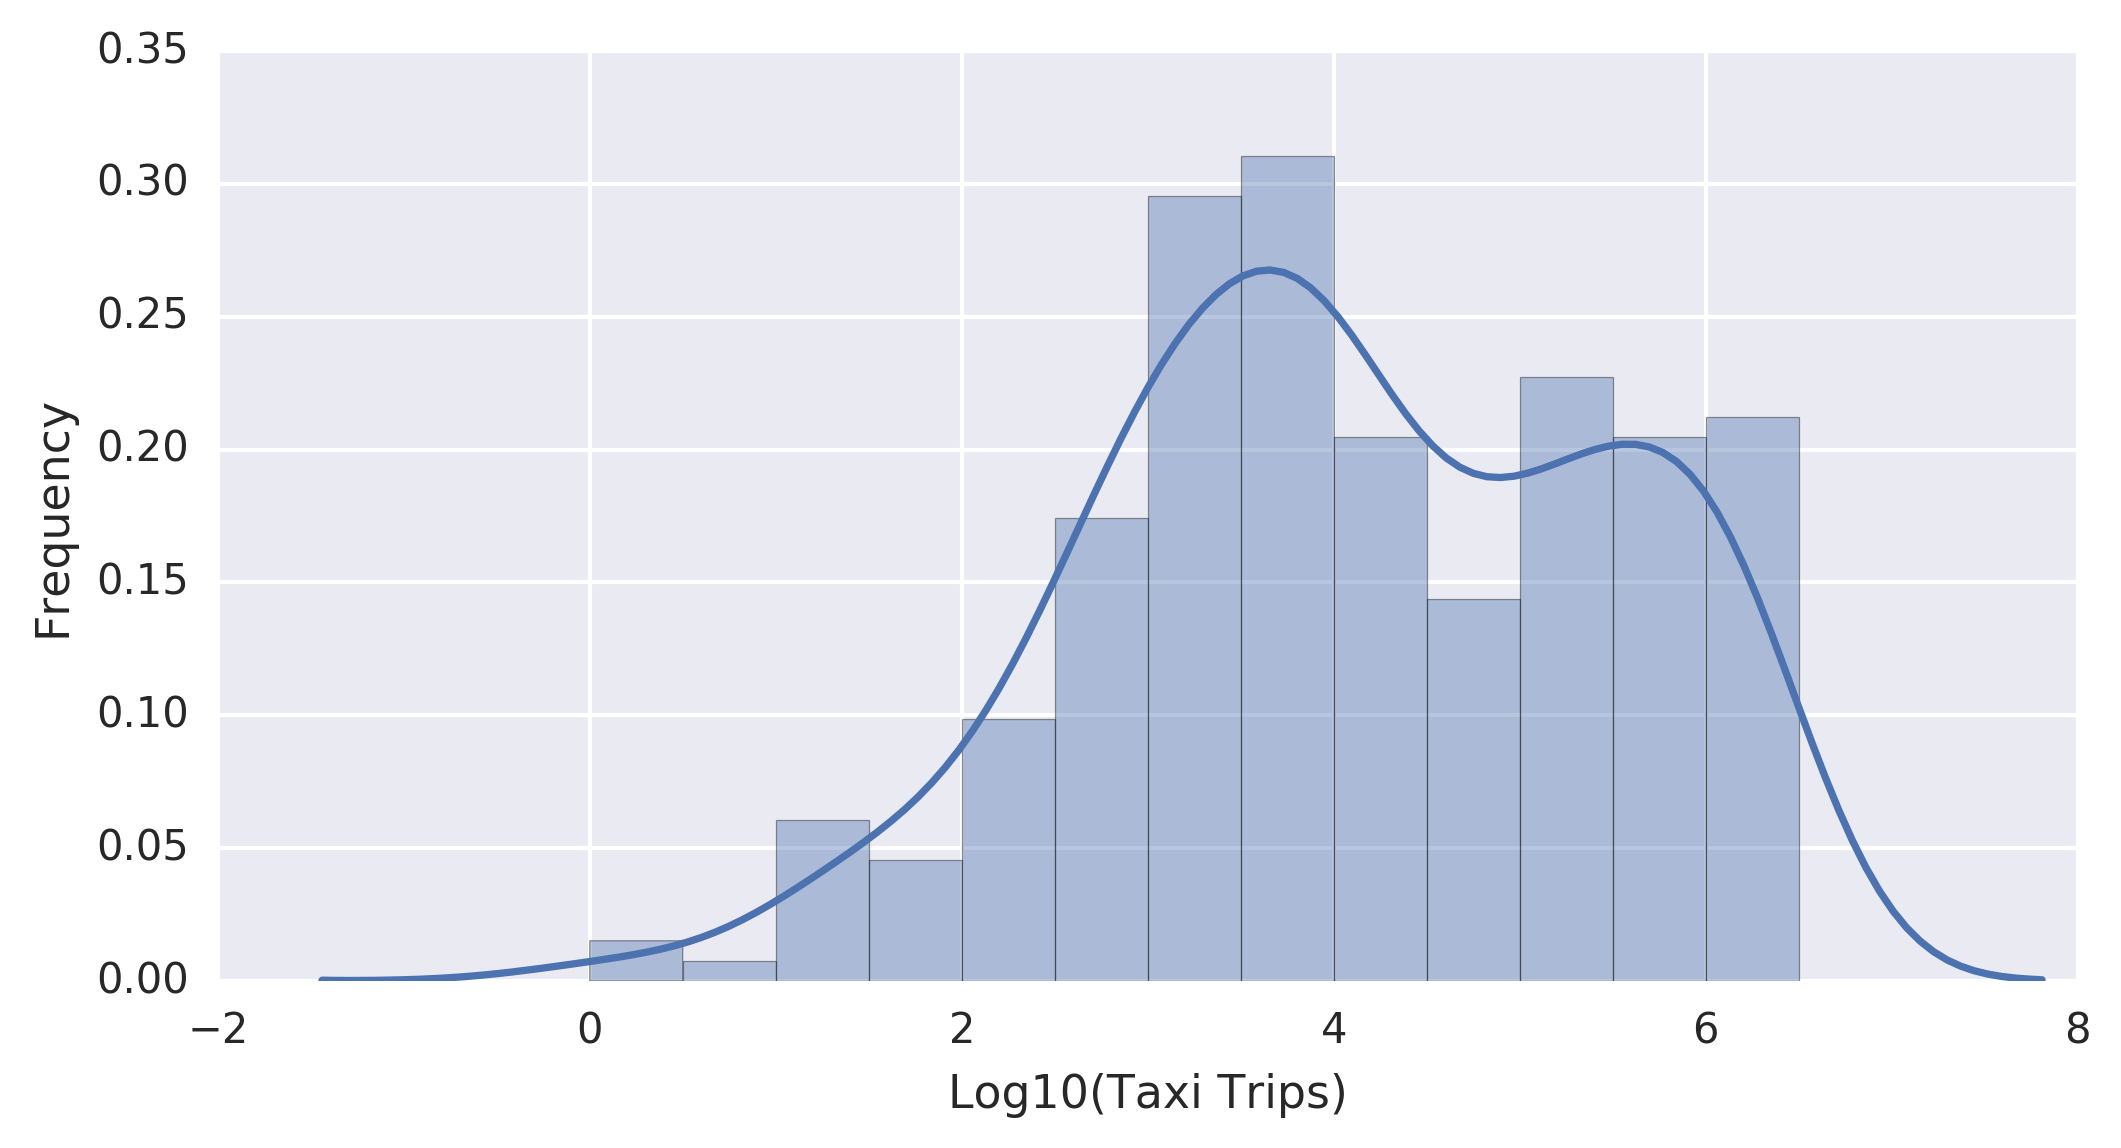

In [31]:
seaborn.distplot(z.logN, bins=np.arange(0, 7., 0.5), norm_hist=True)
# plt.xticks(np.linspace(0, 8, 17));
plt.xlabel("Log10(Taxi Trips)")
plt.ylabel("Frequency")
plt.gcf().set_size_inches(8, 4)

In [20]:
z.columns = ['N', 'logN']

In [21]:
z.head()

,N,logN
pickup_taxizone_id,,
1,4932,3.693023
2,48,1.681241
3,1114,3.046885
4,182516,5.261301
5,18,1.255273


In [33]:
tz = gpd.read_file('../shapefiles/taxi_zones.shp')

In [34]:
tz2 = tz.merge(z, left_on='LocationID', right_index=True)

In [35]:
tz2.head()

,LocationID,OBJECTID,Shape_Area,Shape_Leng,borough,geometry,zone,N,logN
0,1,1,0.000782,0.116357,EWR,"POLYGON ((933100.9183527103 192536.0856972019,...",Newark Airport,4932,3.693023
1,2,2,0.004866,0.433470,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1...",Jamaica Bay,48,1.681241
2,3,3,0.000314,0.084341,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,...",Allerton/Pelham Gardens,1114,3.046885
3,4,4,0.000112,0.043567,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",Alphabet City,182516,5.261301
4,5,5,0.000498,0.092146,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ...",Arden Heights,18,1.255273


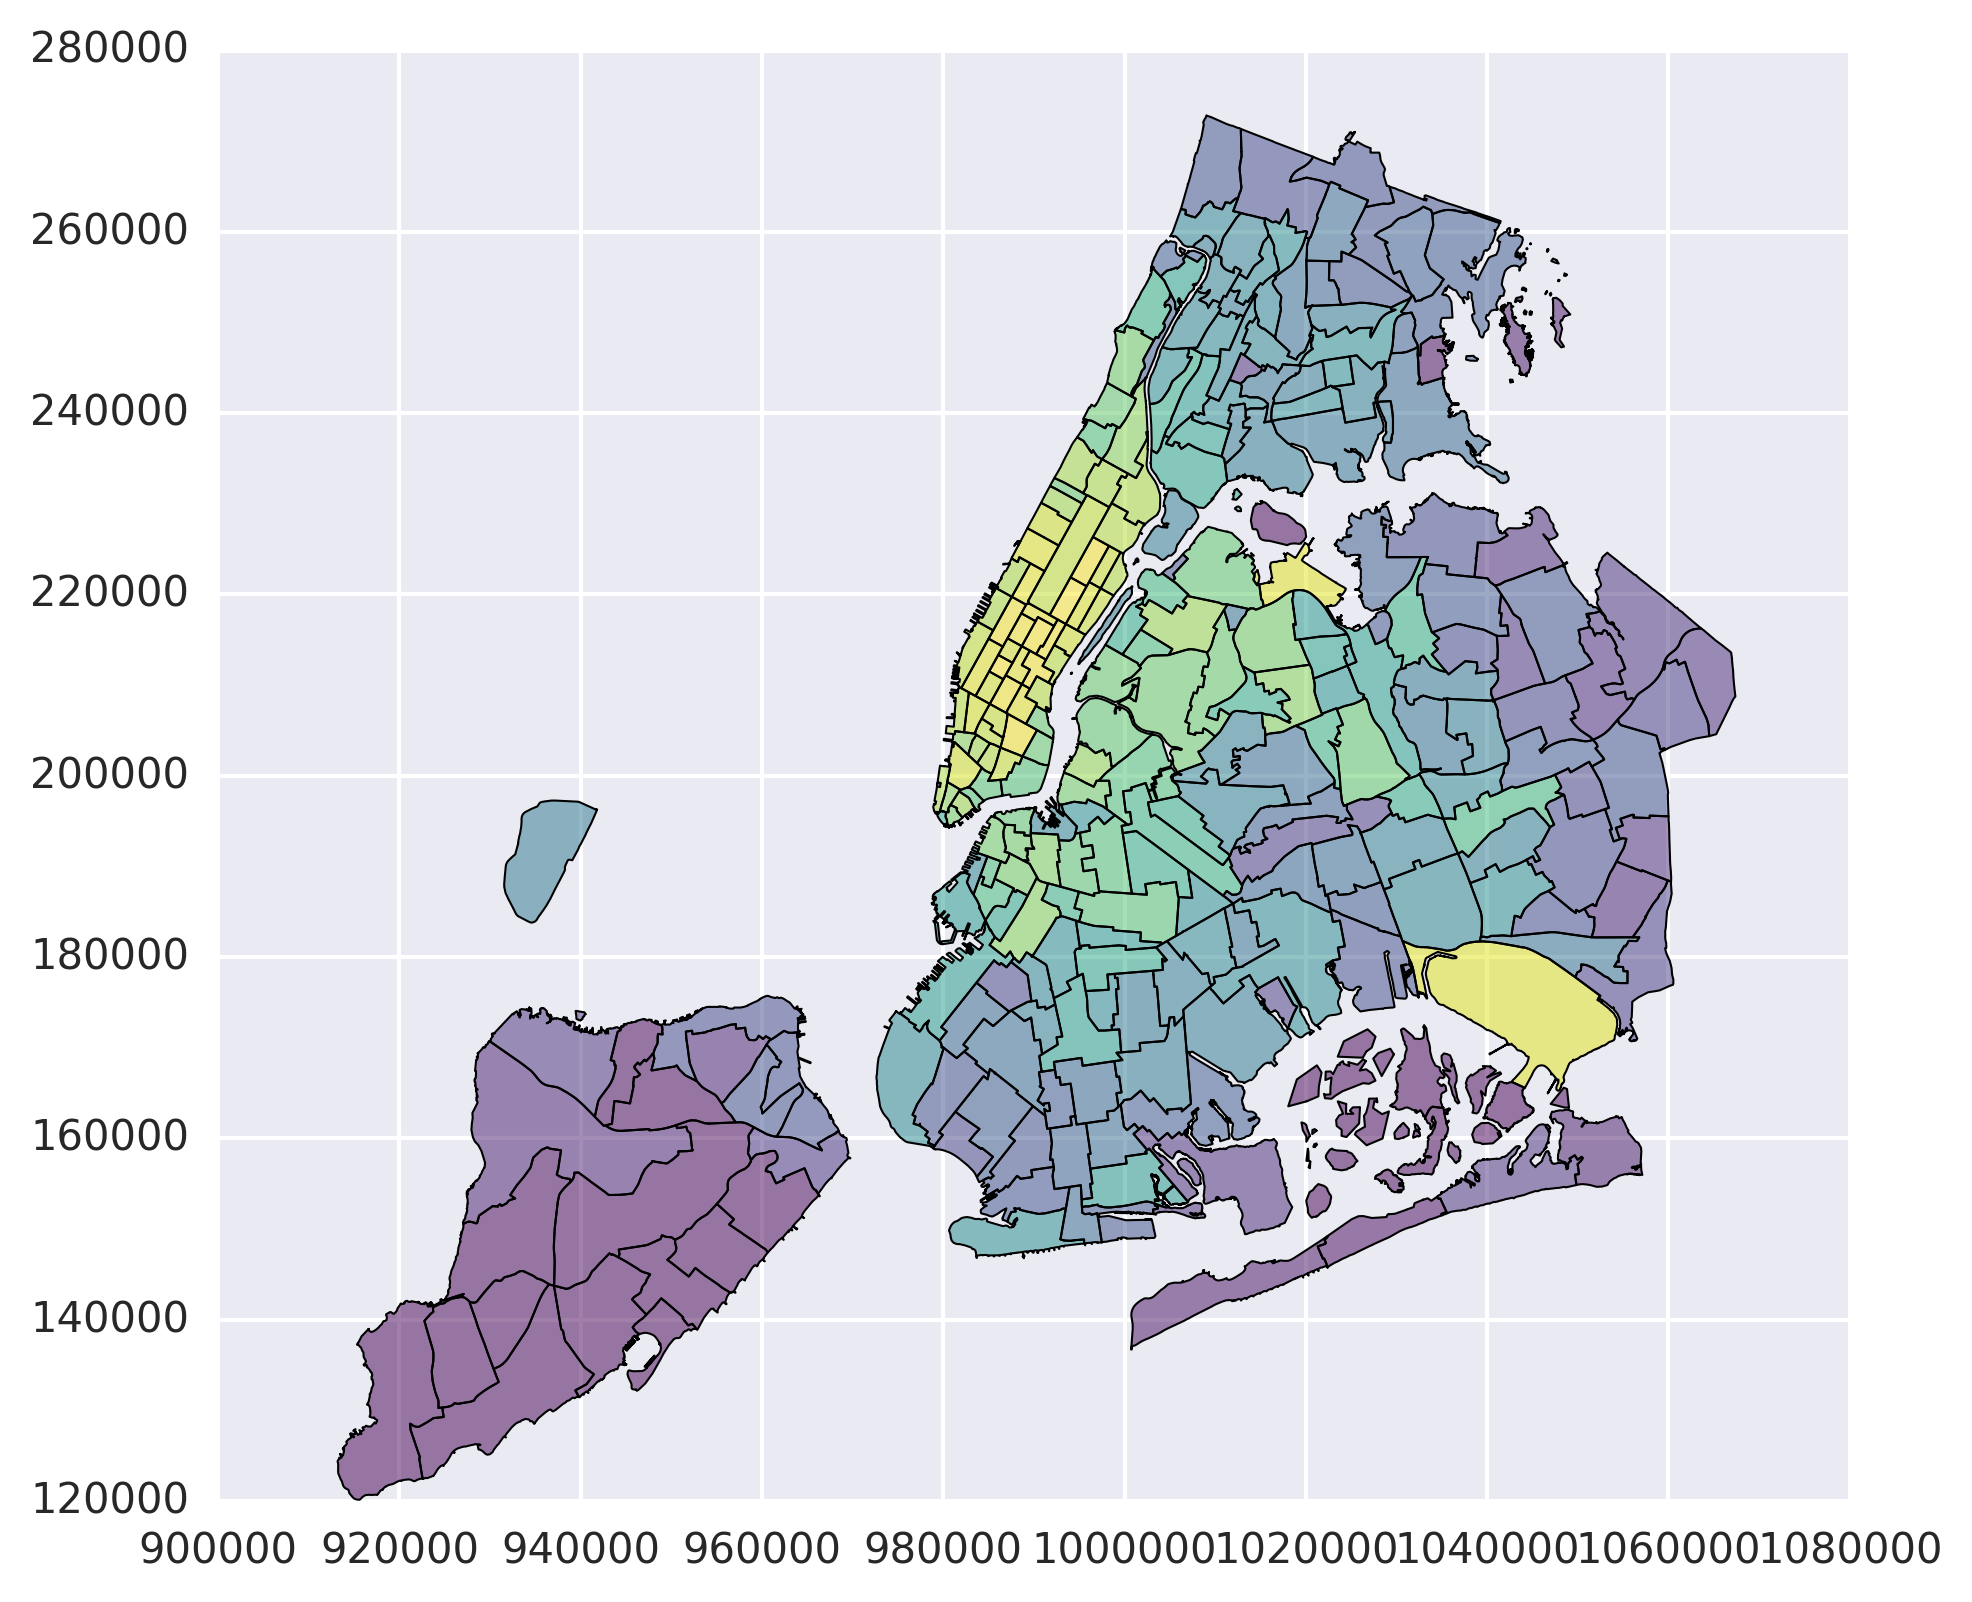

In [36]:
plt.gcf().set_size_inches(12, 9)
tz2.plot(column='logN', cmap=plt.cm.viridis, linewidth=0.5, vmin=2, vmax=6.37)
plt.tight_layout()

In [37]:
tz2 = tz2[(tz2.borough != 'Staten Island')]
tz2 = tz2[(tz2.borough != 'EWR')]

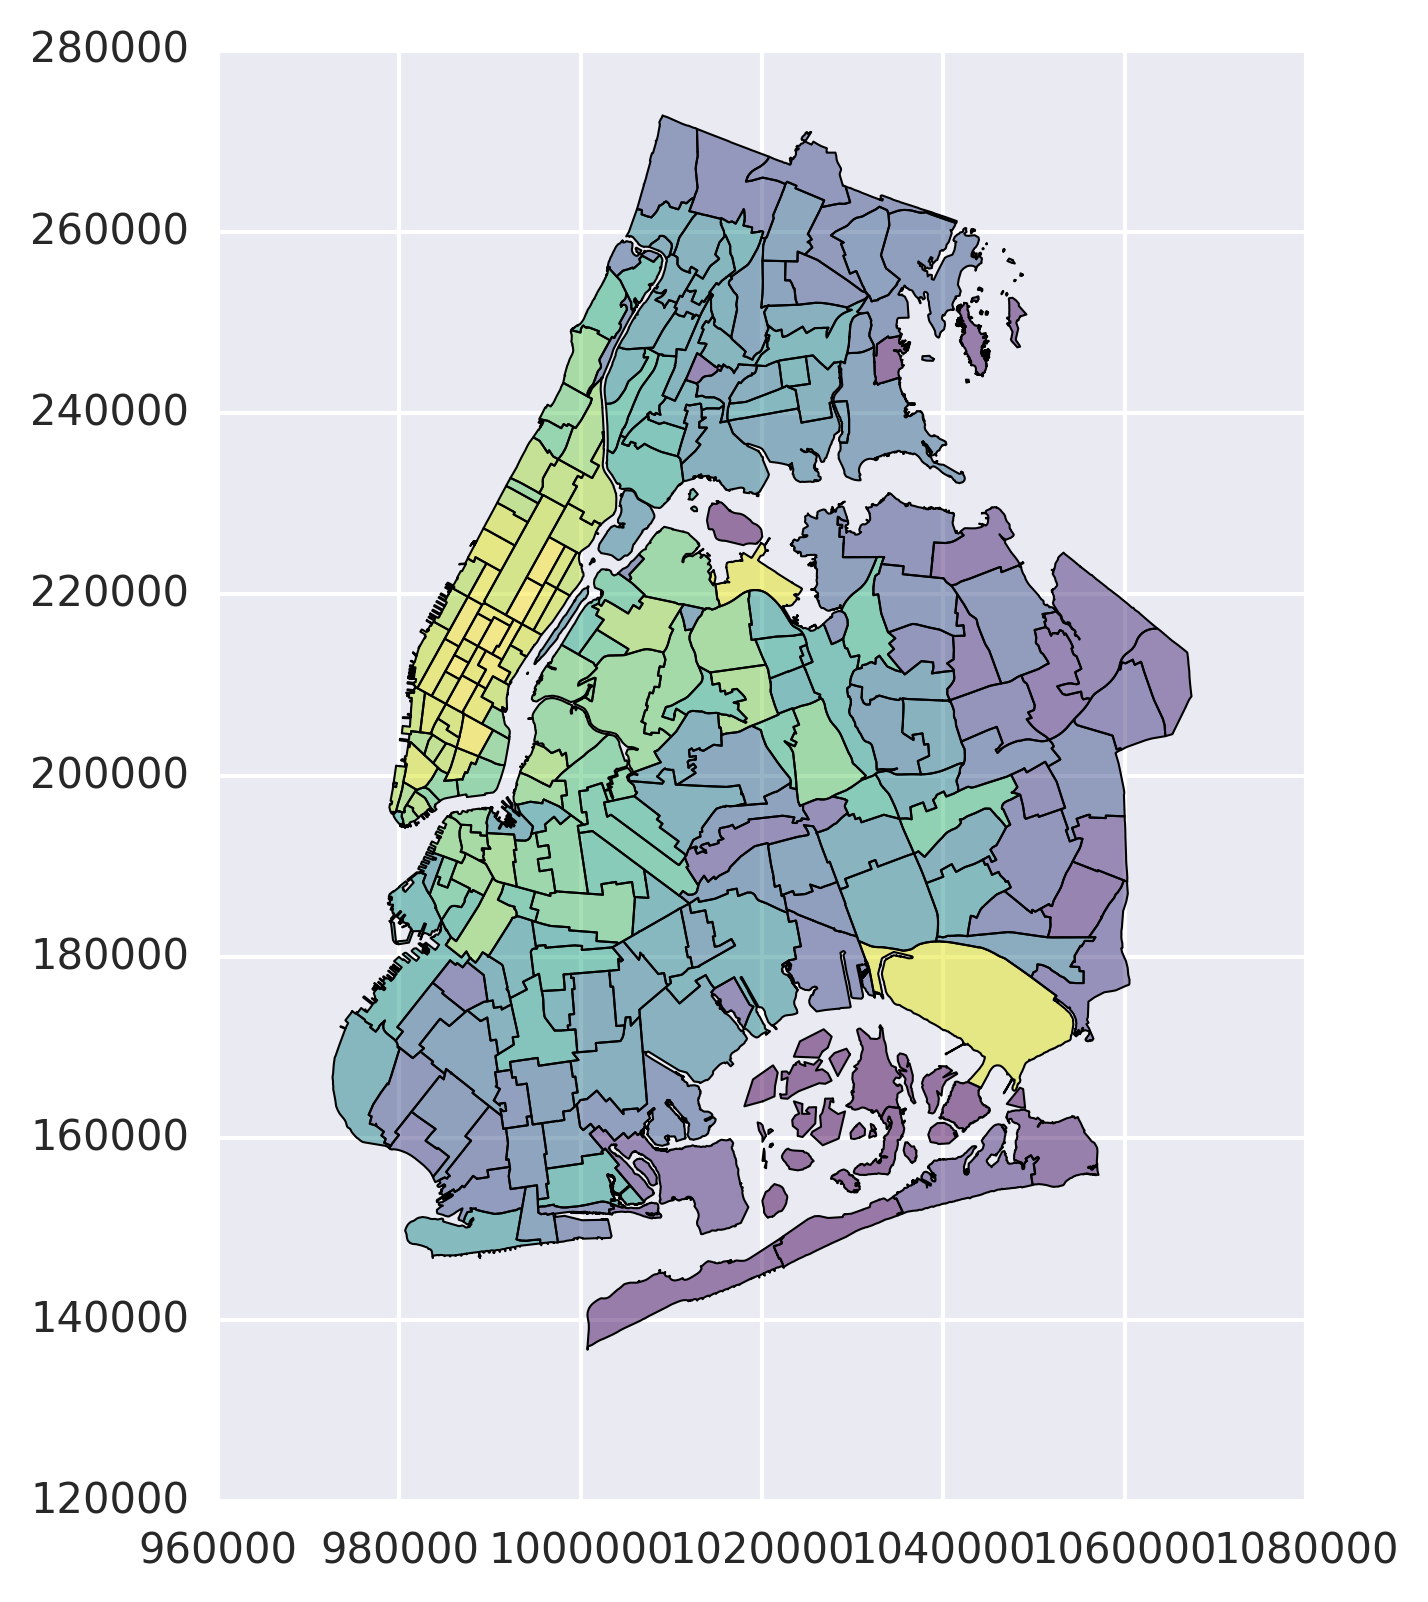

In [38]:
plt.gcf().set_size_inches(12, 9)
tz2.plot(column='logN', cmap=plt.cm.viridis, linewidth=0.5, vmin=2, vmax=6.37)
plt.tight_layout()

In [39]:
tz2.sort_values('N', ascending=False)

,LocationID,OBJECTID,Shape_Area,Shape_Leng,borough,geometry,zone,N,logN
236,237,237,0.000096,0.042213,Manhattan,"POLYGON ((993633.4421878606 216961.0161020756,...",Upper East Side South,2338652,6.368966
160,161,161,0.000072,0.035804,Manhattan,"POLYGON ((991081.0260630846 214453.6983589679,...",Midtown Center,2195829,6.341599
185,186,186,0.000037,0.024696,Manhattan,"POLYGON ((986752.603287071 210853.6989068836, ...",Penn Station/Madison Sq West,2194804,6.341396
235,236,236,0.000103,0.044252,Manhattan,"POLYGON ((995940.0483185351 221122.9204267859,...",Upper East Side North,2109978,6.324278
161,162,162,0.000048,0.035270,Manhattan,"POLYGON ((992224.354090333 214415.2926926613, ...",Midtown East,2042680,6.310200
233,234,234,0.000073,0.036072,Manhattan,"POLYGON ((987029.846865043 207022.299148649, 9...",Union Sq,1999094,6.300833
229,230,230,0.000056,0.031028,Manhattan,"POLYGON ((988786.8773103654 214532.0940539986,...",Times Sq/Theatre District,1989020,6.298639
169,170,170,0.000074,0.045769,Manhattan,"POLYGON ((991999.2986085415 210994.7388307899,...",Murray Hill,1978625,6.296363
47,48,48,0.000094,0.043747,Manhattan,"POLYGON ((986694.3125067502 214463.8461607993,...",Clinton East,1965571,6.293489
78,79,79,0.000108,0.042625,Manhattan,"POLYGON ((988746.0671027899 202151.9547298402,...",East Village,1958027,6.291819
